In [1]:
# brain_tumor_classification.py
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, recall_score, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from torchmetrics import Recall, F1Score, Accuracy
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [3]:
# ============================
# 1. 配置与路径设置
# ============================
DATA_PATH = "D:/dl/brain tumor detection"
NO_PATH = os.path.join(DATA_PATH, "no")
YES_PATH = os.path.join(DATA_PATH, "yes")

# 检查路径是否存在
assert os.path.exists(NO_PATH), f"路径不存在: {NO_PATH}"
assert os.path.exists(YES_PATH), f"路径不存在: {YES_PATH}"

# 设备配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")

使用设备: cuda


In [4]:
# ============================
# 2. 医学图像预处理：颅骨剥离
# ============================
def skull_strip(img: np.ndarray) -> np.ndarray:
    """
    对 MRI 图像进行颅骨剥离
    输入: RGB numpy array (H, W, 3)
    输出: 剥离后的 RGB array
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return img
    largest_contour = max(contours, key=cv2.contourArea)
    mask = np.zeros_like(gray)
    cv2.drawContours(mask, [largest_contour], -1, 255, thickness=cv2.FILLED)
    stripped = cv2.bitwise_and(img, img, mask=mask)
    return stripped

# ============================
# 3. 可 pickle 的 transform 函数（必须在顶层）
# ============================
def skull_strip_transform(img):
    """用于 torchvision transforms 的颅骨剥离函数"""
    return skull_strip(np.array(img))

# ============================
# 4. 自定义 Dataset
# ============================
class BrainTumorDataset(Dataset):
    def __init__(self, no_paths, yes_paths, transform=None):
        self.paths = []
        self.labels = []
        self.transform = transform
        
        for p in no_paths:
            self.paths.append(os.path.join(NO_PATH, p))
            self.labels.append(0)
        for p in yes_paths:
            self.paths.append(os.path.join(YES_PATH, p))
            self.labels.append(1)
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        img_path = self.paths[idx]
        label = self.labels[idx]
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        img = skull_strip(img)
        img = Image.fromarray(img)
        if self.transform:
            img = self.transform(img)
        return img, label

# ============================
# 5. EDA：探索性数据分析
# ============================
def perform_eda():
    print("=== 执行 EDA ===")
    no_imgs = os.listdir(NO_PATH)
    yes_imgs = os.listdir(YES_PATH)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.pie([len(no_imgs), len(yes_imgs)], labels=["No Tumor", "Yes Tumor"], autopct='%1.1f%%')
    plt.title("类别分布")
    
    plt.subplot(1, 2, 2)
    sns.barplot(x=["No Tumor", "Yes Tumor"], y=[len(no_imgs), len(yes_imgs)], palette='viridis')
    plt.title("样本数量")
    plt.tight_layout()
    plt.savefig("eda_class_distribution.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    widths, heights = [], []
    for folder in [NO_PATH, YES_PATH]:
        for img_name in os.listdir(folder):
            try:
                with Image.open(os.path.join(folder, img_name)) as img:
                    w, h = img.size
                    widths.append(w)
                    heights.append(h)
            except:
                continue
    
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(widths, kde=True)
    plt.title('宽度分布')
    plt.subplot(1, 2, 2)
    sns.histplot(heights, kde=True)
    plt.title('高度分布')
    plt.tight_layout()
    plt.savefig("eda_image_size.png", dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"平均尺寸: {np.mean(widths):.0f} x {np.mean(heights):.0f}")
    
    plt.figure(figsize=(15, 6))
    for i, (folder, title) in enumerate([(NO_PATH, "No Tumor"), (YES_PATH, "Yes Tumor")]):
        imgs = os.listdir(folder)[:3]
        for j, img_name in enumerate(imgs):
            plt.subplot(2, 3, i*3 + j + 1)
            img = Image.open(os.path.join(folder, img_name))
            plt.imshow(img)
            plt.title(f"{title}\n{img.size}")
            plt.axis('off')
    plt.tight_layout()
    plt.savefig("eda_samples.png", dpi=150, bbox_inches='tight')
    plt.show()

# ============================
# 6. 传统机器学习方法
# ============================
def extract_hog_features(img_path):
    img = Image.open(img_path).convert("RGB")
    img = np.array(img)
    img = skull_strip(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (128, 128))
    features = hog(gray, orientations=9, pixels_per_cell=(8, 8), 
                   cells_per_block=(2, 2), visualize=False, block_norm='L2-Hys')
    return features

def train_traditional_models():
    print("\n=== 训练传统机器学习模型 ===")
    
    no_imgs = [os.path.join(NO_PATH, img) for img in os.listdir(NO_PATH)]
    yes_imgs = [os.path.join(YES_PATH, img) for img in os.listdir(YES_PATH)]
    
    features = []
    labels = []
    
    print("提取HOG特征...")
    for img_path in tqdm(no_imgs):
        features.append(extract_hog_features(img_path))
        labels.append(0)
    
    for img_path in tqdm(yes_imgs):
        features.append(extract_hog_features(img_path))
        labels.append(1)
    
    features = np.array(features)
    labels = np.array(labels)
    
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    models = {
        "SVM": SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    }
    
    results = {}
    plt.figure(figsize=(10, 8))
    
    for name, model in models.items():
        print(f"训练 {name} 模型...")
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]
        
        acc = accuracy_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        results[name] = {
            "Accuracy": acc,
            "Recall": rec,
            "F1": f1,
            "AUC": roc_auc
        }
        
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')
        
        plt.figure(figsize=(8, 6))
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=["No Tumor", "Tumor"],
                    yticklabels=["No Tumor", "Tumor"])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig(f"confusion_matrix_{name}.png", dpi=150, bbox_inches='tight')
        plt.close()
        
        print(f"{name} - Accuracy: {acc:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}")
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Traditional Models')
    plt.legend(loc="lower right")
    plt.savefig("roc_curves_traditional.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    return results

# ============================
# 7. 模型定义
# ============================
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64 * 28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def get_resnet18(num_classes=2):
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(model.fc.in_features, num_classes)
    )
    return model

def get_efficientnet(num_classes=2):
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    return model

# ============================
# 8. 训练函数
# ============================
def train_model(model, train_loader, val_loader, num_epochs=20, model_name="model"):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=False)
    
    train_metrics = {"loss": [], "recall": [], "f1": [], "accuracy": []}
    val_metrics = {"loss": [], "recall": [], "f1": [], "accuracy": []}
    
    best_f1 = 0.0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_preds, train_labels = [], [], []
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
        
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            train_preds.append(outputs.detach())
            train_labels.append(labels.detach())
        
        model.eval()
        val_loss, val_preds, val_labels = [], [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                val_loss.append(loss.item())
                val_preds.append(outputs)
                val_labels.append(labels)
        
        train_preds = torch.cat(train_preds)
        train_labels = torch.cat(train_labels)
        val_preds = torch.cat(val_preds)
        val_labels = torch.cat(val_labels)
        
        recall_fn = Recall(task="multiclass", num_classes=2, average='macro').to(device)
        f1_fn = F1Score(task="multiclass", num_classes=2, average='macro').to(device)
        acc_fn = Accuracy(task="multiclass", num_classes=2, average='macro').to(device)
        
        train_rec = recall_fn(train_preds, train_labels).item()
        train_f1 = f1_fn(train_preds, train_labels).item()
        train_acc = acc_fn(train_preds, train_labels).item()
        val_rec = recall_fn(val_preds, val_labels).item()
        val_f1 = f1_fn(val_preds, val_labels).item()
        val_acc = acc_fn(val_preds, val_labels).item()
        
        train_metrics["loss"].append(np.mean(train_loss))
        train_metrics["recall"].append(train_rec)
        train_metrics["f1"].append(train_f1)
        train_metrics["accuracy"].append(train_acc)
        val_metrics["loss"].append(np.mean(val_loss))
        val_metrics["recall"].append(val_rec)
        val_metrics["f1"].append(val_f1)
        val_metrics["accuracy"].append(val_acc)
        
        scheduler.step(val_f1)
        
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{model_name}_best.pth")
    
    torch.save(model.state_dict(), f"{model_name}_final.pth")
    
    plt.figure(figsize=(15, 10))
    metrics_to_plot = ["loss", "recall", "f1", "accuracy"]
    for i, metric in enumerate(metrics_to_plot):
        plt.subplot(2, 2, i+1)
        plt.plot(train_metrics[metric], label="Train")
        plt.plot(val_metrics[metric], label="Val")
        plt.title(f"{metric.upper()}")
        plt.xlabel("Epoch")
        plt.legend()
    plt.tight_layout()
    plt.savefig(f"training_curves_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    return model, val_metrics

# ============================
# 9. 评估函数
# ============================
def evaluate_model(model, test_loader, model_name="model"):
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc=f"评估 {model_name}"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs[:, 1].cpu().numpy())
    
    acc = accuracy_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(all_labels, all_preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=["No Tumor", "Tumor"],
                yticklabels=["No Tumor", "Tumor"])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f"confusion_matrix_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc="lower right")
    plt.savefig(f"roc_curve_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    return {
        "Accuracy": acc,
        "Recall": rec,
        "F1": f1,
        "AUC": roc_auc
    }

# ============================
# 10. Grad-CAM 可视化
# ============================
def visualize_gradcam(model, test_loader, model_name="model", save_name="gradcam"):
    model.load_state_dict(torch.load(f"{model_name}_best.pth"))
    model.eval()
    
    if "resnet" in model_name.lower():
        target_layers = [model.layer4[-1]]
    elif "efficientnet" in model_name.lower():
        target_layers = [model.features[-1]]
    else:
        target_layers = [model.features[-2]]
    
    # ✅ 关键修复：新版 GradCAM 不需要 use_cuda
    cam = GradCAM(model=model, target_layers=target_layers)
    
    plt.figure(figsize=(15, 12))
    count = 0
    for imgs, labels in test_loader:
        if count >= 8:
            break
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        
        for i in range(len(imgs)):
            if count >= 8:
                break
                
            img = imgs[i].cpu().numpy().transpose(1, 2, 0)
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            grayscale_cam = cam(input_tensor=imgs[i].unsqueeze(0), 
                               targets=[ClassifierOutputTarget(preds[i].item())])
            grayscale_cam = grayscale_cam[0, :]
            
            visualization = show_cam_on_image(img, grayscale_cam, use_rgb=True)
            
            plt.subplot(4, 4, count*2 + 1)
            true_label = "Tumor" if labels[i].item() == 1 else "No Tumor"
            pred_label = "Tumor" if preds[i].item() == 1 else "No Tumor"
            plt.imshow(img)
            plt.title(f"True: {true_label}\nPred: {pred_label}")
            plt.axis('off')
            
            plt.subplot(4, 4, count*2 + 2)
            plt.imshow(visualization)
            plt.title(f"Grad-CAM\n{model_name}")
            plt.axis('off')
            
            count += 1
    
    plt.tight_layout()
    plt.savefig(f"{save_name}_{model_name}.png", dpi=150, bbox_inches='tight')
    plt.close()

# ============================
# 11. 模型比较
# ============================
def compare_models(results):
    df = pd.DataFrame(results).T
    df.to_csv("model_comparison.csv")
    
    plt.figure(figsize=(15, 10))
    metrics = ["Accuracy", "Recall", "F1", "AUC"]
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(x=df.index, y=df[metric], palette='viridis')
        plt.title(f'Model Comparison - {metric}')
        plt.ylim(0, 1.05)
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("model_comparison.png", dpi=150, bbox_inches='tight')
    plt.close()
    
    print("\n模型比较结果:")
    print(df)
    return df

=== 执行 EDA ===


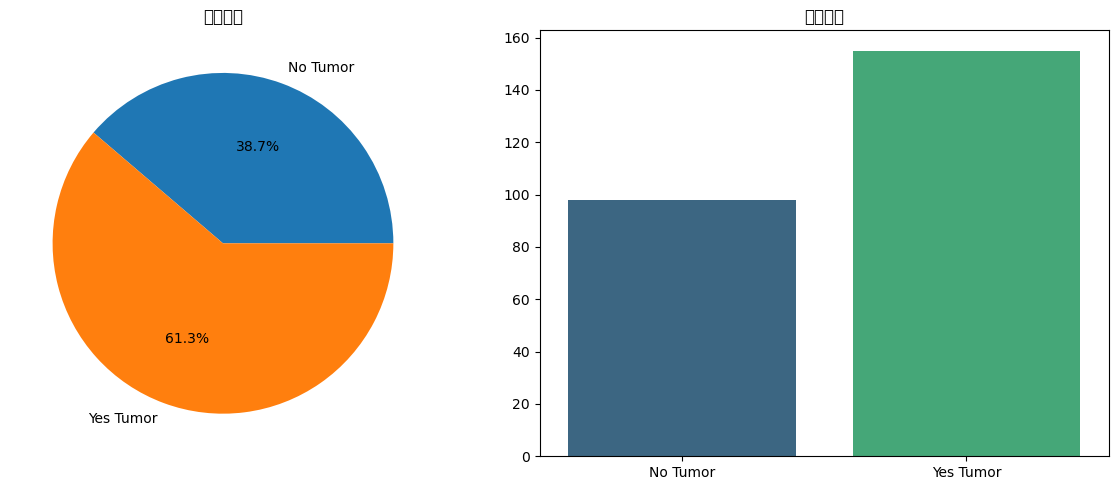

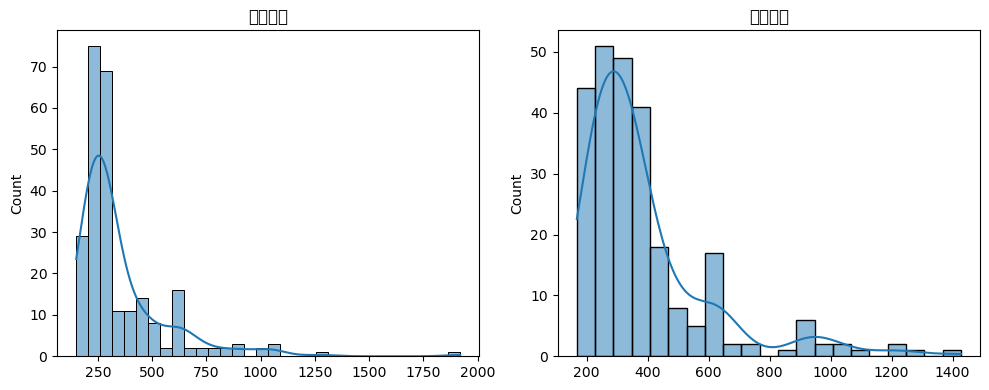

平均尺寸: 354 x 386


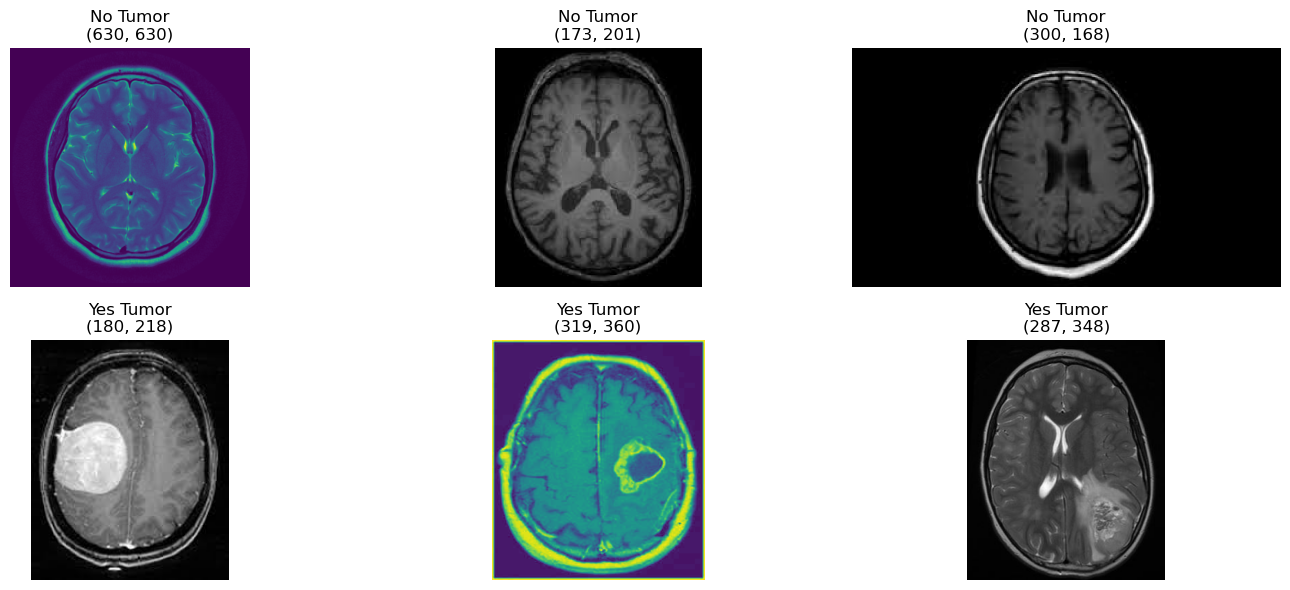

In [5]:
# ============================
# 12. 主流程
# ============================
perform_eda()

In [6]:
no_imgs = os.listdir(NO_PATH)
yes_imgs = os.listdir(YES_PATH)

train_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

full_dataset = BrainTumorDataset(no_imgs, yes_imgs)
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(
    full_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=train_transform)
val_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=val_test_transform)
test_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=val_test_transform)

train_ds = Subset(train_dataset, train_ds.indices)
val_ds = Subset(val_dataset, val_ds.indices)
test_ds = Subset(test_dataset, test_ds.indices)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False, num_workers=0)

print(f"数据集划分: Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")

数据集划分: Train=177, Val=37, Test=39


In [7]:
all_results = {}

# 传统机器学习
print("\n=== 阶段1: 训练传统机器学习模型 ===")
ml_results = train_traditional_models()
for name, metrics in ml_results.items():
    all_results[name] = metrics


=== 阶段1: 训练传统机器学习模型 ===

=== 训练传统机器学习模型 ===
提取HOG特征...


100%|███████████████████████████████████████████████████████████████████████████████| 155/155 [00:01<00:00, 122.70it/s]


训练 SVM 模型...
SVM - Accuracy: 0.8824, Recall: 0.9355, F1: 0.9062, AUC: 0.9452
训练 RandomForest 模型...
RandomForest - Accuracy: 0.8627, Recall: 0.9355, F1: 0.8923, AUC: 0.8968


In [9]:
# SimpleCNN
print("\n=== 阶段2: 训练简单 CNN ===")
cnn_transform = transforms.Compose([
    transforms.Lambda(skull_strip_transform),
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

cnn_dataset = BrainTumorDataset(no_imgs, yes_imgs, transform=cnn_transform)
cnn_train_ds = Subset(cnn_dataset, train_ds.indices)
cnn_val_ds = Subset(cnn_dataset, val_ds.indices)
cnn_test_ds = Subset(cnn_dataset, test_ds.indices)

cnn_train_loader = DataLoader(cnn_train_ds, batch_size=16, shuffle=True, num_workers=0)
cnn_val_loader = DataLoader(cnn_val_ds, batch_size=16, shuffle=False, num_workers=0)
cnn_test_loader = DataLoader(cnn_test_ds, batch_size=16, shuffle=False, num_workers=0)

cnn_model = SimpleCNN()
cnn_model, _ = train_model(cnn_model, cnn_train_loader, cnn_val_loader, num_epochs=30, model_name="cnn")

cnn_metrics = evaluate_model(cnn_model, cnn_test_loader, model_name="cnn")
all_results["SimpleCNN"] = cnn_metrics
visualize_gradcam(cnn_model, cnn_test_loader, model_name="cnn", save_name="gradcam")


=== 阶段2: 训练简单 CNN ===


评估 cnn: 100%|██████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.13it/s]


In [11]:
# ResNet18
print("\n=== 阶段3: 训练 ResNet18 ===")
resnet_model = get_resnet18()
resnet_model, _ = train_model(resnet_model, train_loader, val_loader, num_epochs=30, model_name="resnet")

resnet_metrics = evaluate_model(resnet_model, test_loader, model_name="resnet")
all_results["ResNet18"] = resnet_metrics
visualize_gradcam(resnet_model, test_loader, model_name="resnet", save_name="gradcam")


=== 阶段3: 训练 ResNet18 ===


评估 resnet: 100%|███████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  8.73it/s]


In [12]:
# EfficientNet
print("\n=== 阶段4: 训练 EfficientNet-B0 ===")
efficientnet_model = get_efficientnet()
efficientnet_model, _ = train_model(efficientnet_model, train_loader, val_loader, num_epochs=30, model_name="efficientnet")

efficientnet_metrics = evaluate_model(efficientnet_model, test_loader, model_name="efficientnet")
all_results["EfficientNet-B0"] = efficientnet_metrics
visualize_gradcam(efficientnet_model, test_loader, model_name="efficientnet", save_name="gradcam")


=== 阶段4: 训练 EfficientNet-B0 ===


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to C:\Users\10632/.cache\torch\hub\checkpoints\efficientnet_b0_rwightman-7f5810bc.pth
100%|█████████████████████████████████████████████████████████████████████████████| 20.5M/20.5M [00:10<00:00, 2.14MB/s]
评估 efficientnet: 100%|█████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  7.21it/s]


In [13]:
# 比较
print("\n=== 阶段5: 模型比较 ===")
compare_models(all_results)


=== 阶段5: 模型比较 ===

模型比较结果:
                 Accuracy    Recall        F1       AUC
SVM              0.882353  0.935484  0.906250  0.945161
RandomForest     0.862745  0.935484  0.892308  0.896774
SimpleCNN        0.769231  0.740741  0.816327  0.876543
ResNet18         0.846154  0.814815  0.880000  0.966049
EfficientNet-B0  0.871795  0.814815  0.897959  0.981481


,Accuracy,Recall,F1,AUC
SVM,0.882353,0.935484,0.906250,0.945161
RandomForest,0.862745,0.935484,0.892308,0.896774
SimpleCNN,0.769231,0.740741,0.816327,0.876543
ResNet18,0.846154,0.814815,0.880000,0.966049
EfficientNet-B0,0.871795,0.814815,0.897959,0.981481
